#**Cropping and maskinng core scan boxes using pre-trained models**

This notebook will demonstrate how to remove the background of the image and mask the corebox. This notebook uses three pre-trained models (downloadable from *ADD link once download is ready*):


*   Box_picker_YOLO.pt
*   Trained_MWIR_Model_27-4-24.pkl
*   Trained_MWIR_Model_27-4-24.pkl

The first model used is a YOLOv8 model designed to identify the core box in the wider image, allowing the back ground to be cropped out. This model was produced by researchers at Guangxi Normal University in collaboration with researchers from University College Dublin, Trinity College Dublin and Geological Survey Ireland. Full details are in:

Hongyan Zhu, Anjie Li, Chengzhi Lin, Shuai Qin, Junhao Xie, Jackey J. K. Chai, Russell Rogers, Jun-Li Xu. **A YOLOv8-Powered Framework for Automated Hyperspectral Core Analysis** *Remote Sensing of Environment* (*in prep*)

The other two models were developed by Geological Survey Ireland and are designed to detect wooden corebox material (the most common box material in the Geological Survey Ireland dataset). This model is a scikit-learn MLP classifier trained on ~300 selected images where the labels were generated by using pearson correlation coefficients of core box material.  These models were created because the pearson correlation work best on continuum removed spectra and identifying the box in reflectance data is a quicker workflow. One model is for SWIR range data and the other is for MWIR range data.

To use this workbook you will need to download the models and the example data from Geological Survey Ireland's website: *add link here*

First, we will need to install ultralytics and import all the modules that we will need.






In [73]:
!pip install ultralytics
import spectral as sp
import numpy as np
import matplotlib.pyplot as plt
import pickle
from ultralytics import YOLO
import sklearn
plt.rcParams['figure.dpi'] = 150
import spectral.io.envi as envi
import pickle
yolo_model = YOLO("/content/drive/MyDrive/Public_Data/Box_picker_YOLO.pt") # This should be a path to your saved YOLO model
with open('/content/drive/MyDrive/Public_Data/Trained_SWIR_Model_27-4-24.pkl','rb') as f: # This should be a path to your saved SWIR model
            swir_mask_model = pickle.load(f)
with open('/content/drive/MyDrive/Public_Data/Trained_MWIR_Model_27-4-24.pkl','rb') as f: # This should be a path to your saved MWIR model
            mwir_mask_model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


We need to open the raw data and the white and dark references using the spectral python envi module.

In [72]:
raw_swir_data = envi.open('/content/drive/MyDrive/Public_Data/DATA/SWIR/17_7_BALLYBAUN_25_105m98_110m35_2022-10-07_10-55-29.hdr')#This should be a path to your saved SWIR raw
raw_swir_white = envi.open('/content/drive/MyDrive/Public_Data/DATA/SWIR/WHITEREF_17_7_BALLYBAUN_25_105m98_110m35_2022-10-07_10-55-29.hdr')#This should be a path to your saved SWIR white
raw_swir_dark = envi.open('/content/drive/MyDrive/Public_Data/DATA/SWIR/DARKREF_17_7_BALLYBAUN_25_105m98_110m35_2022-10-07_10-55-29.hdr')#This should be a path to your saved SWIR dark

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


The raw data needs to be corrected to reflectance, and the noisy bands at the edges need to be removed

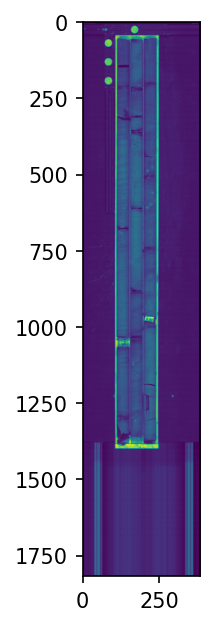

In [74]:
def get_reflect(raw_data, raw_white, raw_dark, mode='SWIR'):
  data = np.array(raw_data.load())
  white = np.array(raw_white.load())
  dark = np.array(raw_dark.load())
  if mode == 'SWIR':
    data = data[:, :, 13:262]
    white = white[:, :, 13:262]
    dark = dark[:, :, 13:262]
  elif mode == 'MWIR':
    data = data[:, :, 5:147]
    white = white[:, :, 5:147]
    dark = dark[:, :, 5:147]
  wmax = np.mean(white, axis=0)
  dmin = np.mean(dark, axis=0)
  reflect = np.divide(np.subtract(data, dmin), np.subtract(wmax, dmin))
  reflect[reflect < 0] = 0
  reflect = reflect * 100
  return reflect
reflect = get_reflect(raw_swir_data, raw_swir_white, raw_swir_dark, mode='SWIR')
plt.figure()
plt.imshow(reflect[:,:,9])

The YOLO model is method independent. It has been trained to recognise the core box in MWIR, SWIR and RGB images.

The model will accept inputs in the RGB format with data-type uint8, so the SWIR and MWIR images will need to be converted. The bands given in this function are the default bands given in the data headers, but other bands may be as effective. The conversion selects the three bands, normalises each to be between 0-1 and then multiplies them by 255 to produce an RGB image.

The geometry of the bounding box identified by the YOLO model can then be used to produce coordinates to crop the image.


0: 640x160 1 box, 423.5ms
Speed: 10.8ms preprocess, 423.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)


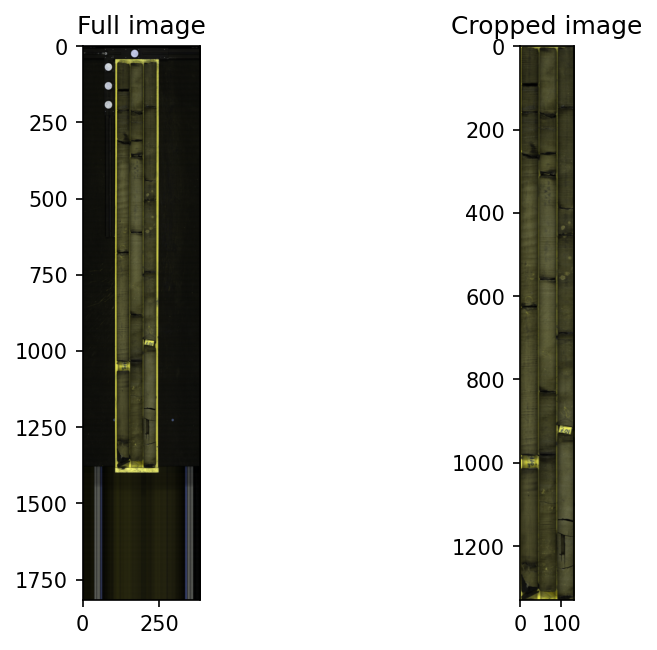

In [75]:
def get_coords(box):
    yolo_x, yolo_y, yolo_width, yolo_height = box.xywhn[0].tolist()
    image_height, image_width = box.orig_shape
    center_x = yolo_x * image_width
    center_y = yolo_y * image_height
    left_top_x = center_x - ((yolo_width * image_width)/2)
    left_top_y = center_y - ((yolo_height * image_height)/2)
    right_top_x = center_x + ((yolo_width * image_width)/2)
    right_top_y = center_y - ((yolo_height * image_height)/2)
    right_bottom_x = box.xyxyn[0].tolist()[2] * image_width
    right_bottom_y = box.xyxyn[0].tolist()[3] * image_height
    left_bottom_x = center_x - ((yolo_width * image_width)/2)
    left_bottom_y = center_y + ((yolo_height * image_height)/2)
    cropping_coords = np.array((left_top_y, right_bottom_y,left_top_x, right_bottom_x )).astype(np.uint32)
    return cropping_coords
def crop(reflect, mode = 'SWIR'):
    if mode == 'SWIR':
      reflect_bgr = reflect[:,:,(4, 14, 225)]
    elif mode == 'MWIR':
      reflect_bgr = reflect[:,:,(56, 124, 17)]
    reflect_bgr[:,:,0] = (reflect_bgr[:,:,0]/np.max(reflect_bgr[:,:,0]))*255
    reflect_bgr[:,:,1] = (reflect_bgr[:,:,1]/np.max(reflect_bgr[:,:,1]))*255
    reflect_bgr[:,:,2] = (reflect_bgr[:,:,2]/np.max(reflect_bgr[:,:,2]))*255
    reflect_bgr = reflect_bgr.astype(np.uint8)
    #====================crop using YOLO model=================================================
    results = yolo_model.predict(reflect_bgr)
    result = results[0]
    box = result.boxes[0]
    crops = get_coords(box)
    reflect_cropped = reflect[crops[0]:crops[1], crops[2]:crops[3]]
    reflect_bgr_cropped = reflect_bgr[crops[0]:crops[1], crops[2]:crops[3]]
    plt.figure()
    plt.subplot(121)
    plt.imshow(reflect_bgr)
    plt.title('Full image')
    plt.subplot(122)
    plt.imshow(reflect_bgr_cropped)
    plt.title('Cropped image')
    return reflect_cropped
reflect_cropped = crop(reflect, mode='SWIR')



The MLP classifier can only accept 2D arrays, so the first step in this function is to reshape the cropped reflectance data. Both of the masking models label core box pixels as "2". The mask is derived from the re-shaped labeled data with values of 0 and 1 which can be used in numpy masked arrays.


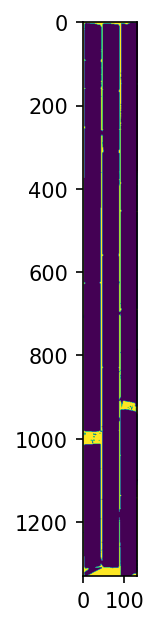

In [76]:
def generate_mask(data, model):
    test_dataset = np.reshape(data, (-1, data.shape[-1]))
    test_dataset[np.isnan(test_dataset)] = 0
    output = model.predict(test_dataset)
    reshaped = np.reshape(output,(data.shape[0], -1))
    main_mask = np.zeros_like(reshaped)
    main_mask[reshaped==2] =1
    plt.figure()
    plt.imshow(main_mask, cmap='viridis')
    return main_mask
mask = generate_mask(reflect_cropped, swir_mask_model)

Once the image has been cropped and the mask produced the image can be concatenated horizontally by providing the number of runs.

(1331, 134, 249) (1331, 134)


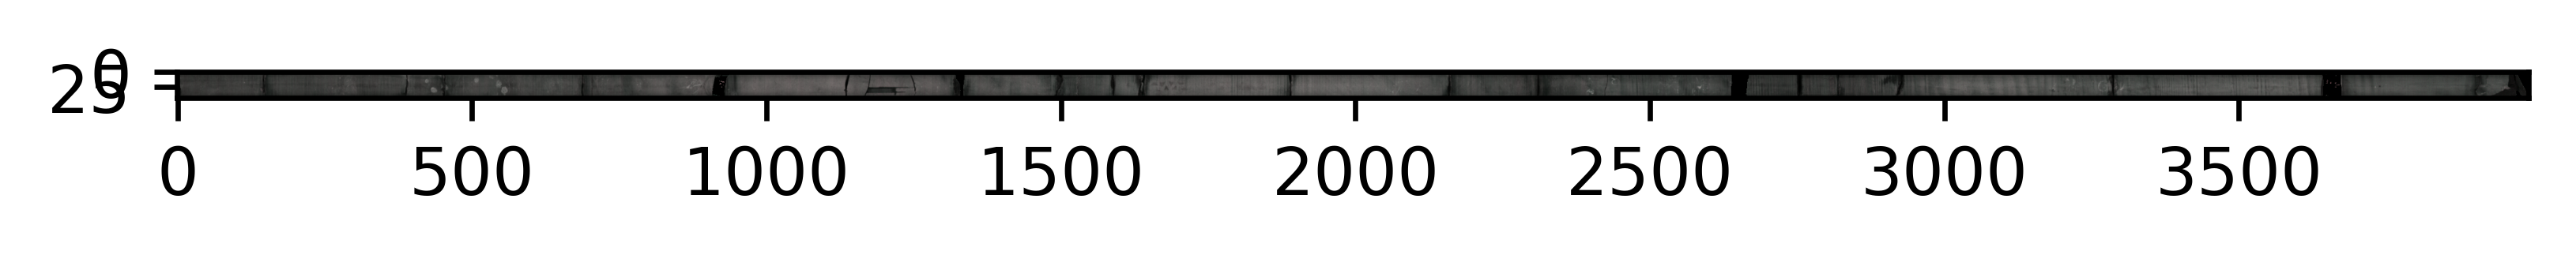

In [64]:
import math
def horizontal_concatenation(data, mask, num_runs):
    work_mask = np.flip(np.swapaxes(mask, 0, 1), axis=0)
    data = np.flip(np.swapaxes(data, 0, 1), axis=0)
    split_width = math.floor(work_mask.shape[0]/num_runs)

    new_im = np.zeros((split_width, 1, data.shape[2]))
    new_mask = np.zeros((split_width, 1))
    for i in range(num_runs):
        new_im = np.hstack((new_im, data[:split_width, :]))
        data = data[split_width:, :]
        new_mask = np.hstack((new_mask, work_mask[:split_width, :]))
        work_mask = work_mask[split_width:, :]

    hmask = new_mask[:,1:]
    himage =  new_im[:,1:,:]
    return himage, hmask
horizontal_reflect, horizontal_mask = horizontal_concatenation(reflect_cropped, mask, 3)
horizontal_bgr = horizontal_reflect[:,:,(41, 1, 10)]
horizontal_bgr[:,:,0] = (horizontal_bgr[:,:,0]/np.max(horizontal_bgr[:,:,0]))*255
horizontal_bgr[:,:,1] = (horizontal_bgr[:,:,1]/np.max(horizontal_bgr[:,:,1]))*255
horizontal_bgr[:,:,2] = (horizontal_bgr[:,:,2]/np.max(horizontal_bgr[:,:,2]))*255
horizontal_bgr = horizontal_bgr.astype(np.uint8)
horizontal_bgr[horizontal_mask==1] = [0,0,0]
plt.rcParams['figure.dpi'] = 600
plt.figure()
plt.imshow(horizontal_bgr)

By changing the mode of the functions, the exact same process can be used for masking and cropping raw MWIR range data.

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)



0: 640x160 1 box, 645.3ms
Speed: 28.7ms preprocess, 645.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 160)


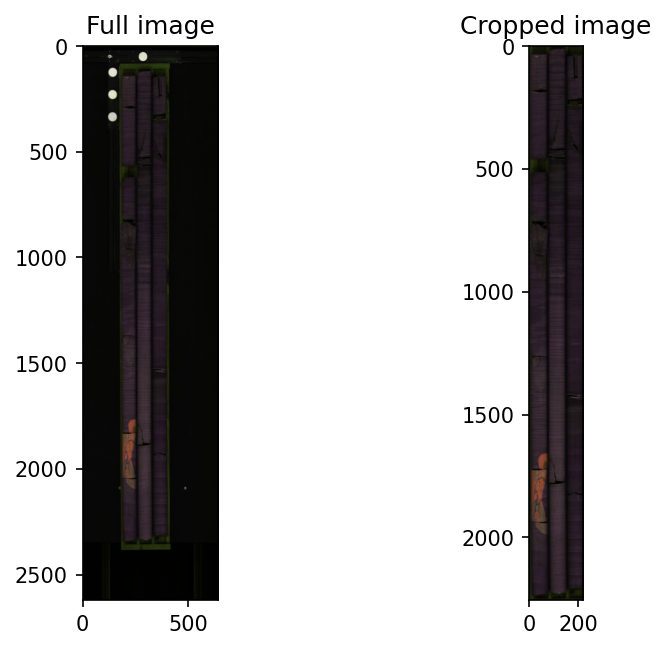

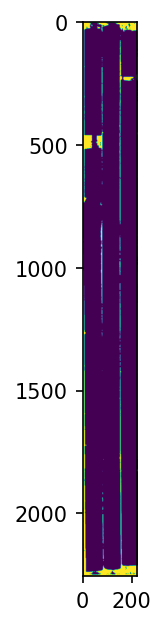

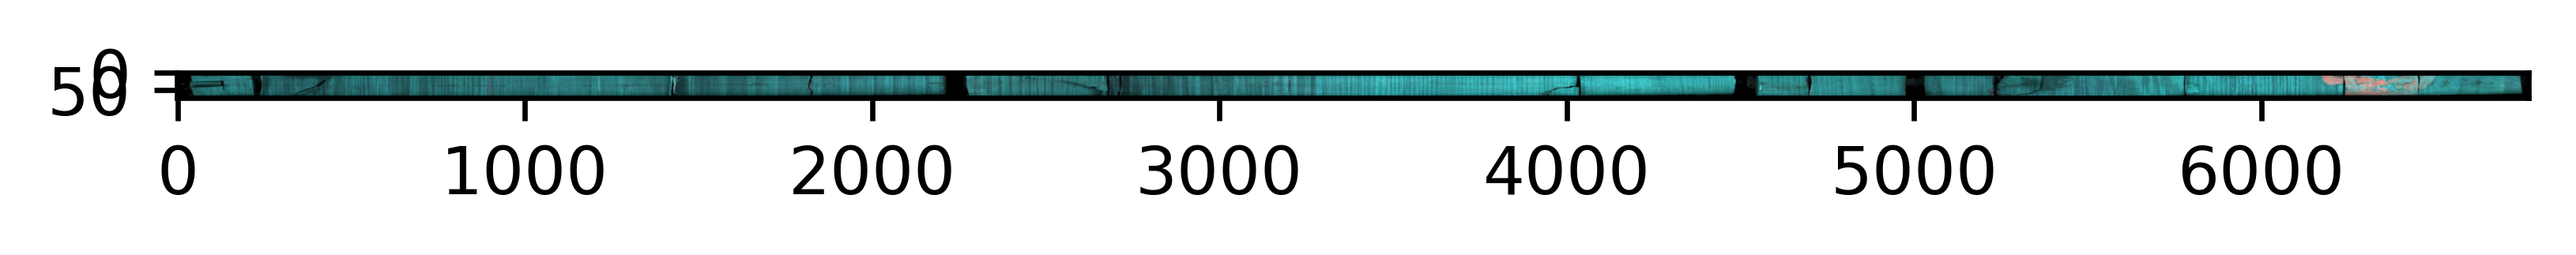

In [78]:
raw_mwir_data = envi.open('/content/drive/MyDrive/Public_Data/DATA/MWIR/17_7_BALLYBAUN_37_157m95_162m15_2022-10-07_11-27-19.hdr')#This should be a path to your saved MWIR raw
raw_mwir_white = envi.open('/content/drive/MyDrive/Public_Data/DATA/MWIR/WHITEREF_17_7_BALLYBAUN_37_157m95_162m15_2022-10-07_11-27-19.hdr')#This should be a path to your saved MWIR white reference
raw_mwir_dark = envi.open('/content/drive/MyDrive/Public_Data/DATA/MWIR/DARKREF_17_7_BALLYBAUN_37_157m95_162m15_2022-10-07_11-27-19.hdr')#This should be a path to your saved MWIR dark reference

reflect_mwir = get_reflect(raw_mwir_data, raw_mwir_white, raw_mwir_dark, mode='MWIR')
plt.rcParams['figure.dpi'] = 150

reflect_cropped_mwir = crop(reflect_mwir, mode='MWIR')
mwir_mask = generate_mask(reflect_cropped_mwir, mwir_mask_model)
horizontal_reflect_mwir, horizontal_mask_mwir = horizontal_concatenation(reflect_cropped_mwir, mwir_mask, 3)
horizontal_bgr_mwir = horizontal_reflect_mwir[:,:,(41, 1, 10)]
horizontal_bgr_mwir[:,:,0] = (horizontal_bgr_mwir[:,:,0]/np.max(horizontal_bgr_mwir[:,:,0]))*255
horizontal_bgr_mwir[:,:,1] = (horizontal_bgr_mwir[:,:,1]/np.max(horizontal_bgr_mwir[:,:,1]))*255
horizontal_bgr_mwir[:,:,2] = (horizontal_bgr_mwir[:,:,2]/np.max(horizontal_bgr_mwir[:,:,2]))*255
horizontal_bgr_mwir = horizontal_bgr_mwir.astype(np.uint8)
horizontal_bgr_mwir[horizontal_mask_mwir==1] = [0,0,0]
plt.rcParams['figure.dpi'] = 600
plt.figure()
plt.imshow(horizontal_bgr_mwir)